In [235]:
import pycaret
import pandas as pd

In [236]:
# อ่านไฟล์ CSV
data = pd.read_csv('../export_data/filtered_data_3_best.csv')

In [237]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data = data.asfreq('D')  # 'D' สำหรับรายวัน

In [238]:
# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data[data.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data[data.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")


row = data.loc["2023-09-30 07:00:00"]
row

แถวที่มีค่าหายไปก่อนเติม:
                     humidity  pm_10  pm_2_5  pm_2_5_sp  temperature
timestamp                                                           
2023-09-30 07:00:00       NaN    NaN     NaN        NaN          NaN
ไม่มีค่าหายไปแล้ว


humidity       82.889367
pm_10          60.525519
pm_2_5         53.415241
pm_2_5_sp      69.527667
temperature    29.219760
Name: 2023-09-30 07:00:00, dtype: float64

In [239]:
data = data[['pm_2_5', 'humidity', 'temperature']]

In [240]:
from scipy import stats
import numpy as np

# คำนวณ Z-score
z_scores = np.abs(stats.zscore(data[['humidity', 'temperature', 'pm_2_5']]))

# กำหนด threshold เป็น 3 (ค่าเกิน 3 ถือว่าผิดปกติ)
threshold = 5

# แทนค่าผิดปกติด้วยค่าเฉลี่ยของคอลัมน์นั้นๆ
for col in ['humidity', 'temperature', 'pm_2_5']:
    mean_value = data[col].mean()  # หาค่าเฉลี่ยของคอลัมน์
    data.loc[z_scores[col] > threshold, col] = mean_value  # แทนค่าที่เป็น outlier

In [241]:
data["year"] = data.index.year
data["month"] = data.index.month
data["day"] = data.index.day
data["day_of_week"] = data.index.dayofweek  # 0 = Monday, 6 = Sunday
data["week_of_year"] = data.index.isocalendar().week  # ค่าจะเป็น int64

In [242]:
# สมมติว่า data มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data["season"] = data.index.month.map(assign_season)
data['season'] = data['season'].map(season_mapping)

In [243]:
data['dew_point'] = data['temperature'] - ((100 - data['humidity']) / 5)

In [244]:
data["is_weekend"] = data.index.dayofweek.isin([5, 6]).astype(int)

In [245]:
# อัตราส่วนของอุณหภูมิต่อความชื้น
data["temp_humidity_ratio"] = data["temperature"] / (data["humidity"] + 1)

In [246]:
# ดัชนีความร้อน (Heat Index) หรืออุณหภูมิที่รับรู้
T = data["temperature"]
RH = data["humidity"]

data["heat_index"] = -42.379 + (2.04901523 * T) + (10.14333127 * RH) - (0.22475541 * T * RH) - \
                   (0.00683783 * T**2) - (0.05481717 * RH**2) + (0.00122874 * T**2 * RH) + \
                   (0.00085282 * T * RH**2) - (0.00000199 * T**2 * RH**2)

In [247]:
# ความชื้นสัมพัทธ์เชิงดัชนี
data["rh_index"] = data["humidity"] ** 2 / (data["temperature"] + 1)

In [248]:
import pandas as pd
import numpy as np

# สมมุติว่ามี DataFrame data ที่มีข้อมูลอยู่แล้ว

# เพิ่มฟีเจอร์ day_of_year
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['day_of_year'] = data['date'].dt.dayofyear

# เพิ่มฟีเจอร์ month_sin และ month_cos
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

data['pm_2_5_lag_1'] = data['pm_2_5'].shift(1)
data['pm_2_5_lag_2'] = data['pm_2_5'].shift(2)
data['pm_2_5_lag_3'] = data['pm_2_5'].shift(3)
data['pm_2_5_lag_4'] = data['pm_2_5'].shift(4)
data['pm_2_5_lag_5'] = data['pm_2_5'].shift(5)
data['pm_2_5_lag_6'] = data['pm_2_5'].shift(6)
data['pm_2_5_lag_7'] = data['pm_2_5'].shift(7)

data['humidity_lag_1'] = data['humidity'].shift(1)
data['humidity_lag_2'] = data['humidity'].shift(2)
data['humidity_lag_3'] = data['humidity'].shift(3)
data['humidity_lag_5'] = data['humidity'].shift(5)
data['humidity_lag_7'] = data['humidity'].shift(7)

data['temperature_lag_1'] = data['temperature'].shift(1)
data['temperature_lag_2'] = data['temperature'].shift(2)
data['temperature_lag_3'] = data['temperature'].shift(3)
data['temperature_lag_5'] = data['temperature'].shift(5)
data['temperature_lag_7'] = data['temperature'].shift(7)


In [249]:
data["temp_diff"] = data["temperature"].diff()
data["humidity_diff"] = data["humidity"].diff()

In [250]:
data.columns

Index(['pm_2_5', 'humidity', 'temperature', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'season', 'dew_point', 'is_weekend',
       'temp_humidity_ratio', 'heat_index', 'rh_index', 'date', 'day_of_year',
       'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
       'pm_2_5_lag_1', 'pm_2_5_lag_2', 'pm_2_5_lag_3', 'pm_2_5_lag_4',
       'pm_2_5_lag_5', 'pm_2_5_lag_6', 'pm_2_5_lag_7', 'humidity_lag_1',
       'humidity_lag_2', 'humidity_lag_3', 'humidity_lag_5', 'humidity_lag_7',
       'temperature_lag_1', 'temperature_lag_2', 'temperature_lag_3',
       'temperature_lag_5', 'temperature_lag_7', 'temp_diff', 'humidity_diff'],
      dtype='object')

In [251]:
data_filtered = data.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

<Axes: xlabel='timestamp'>

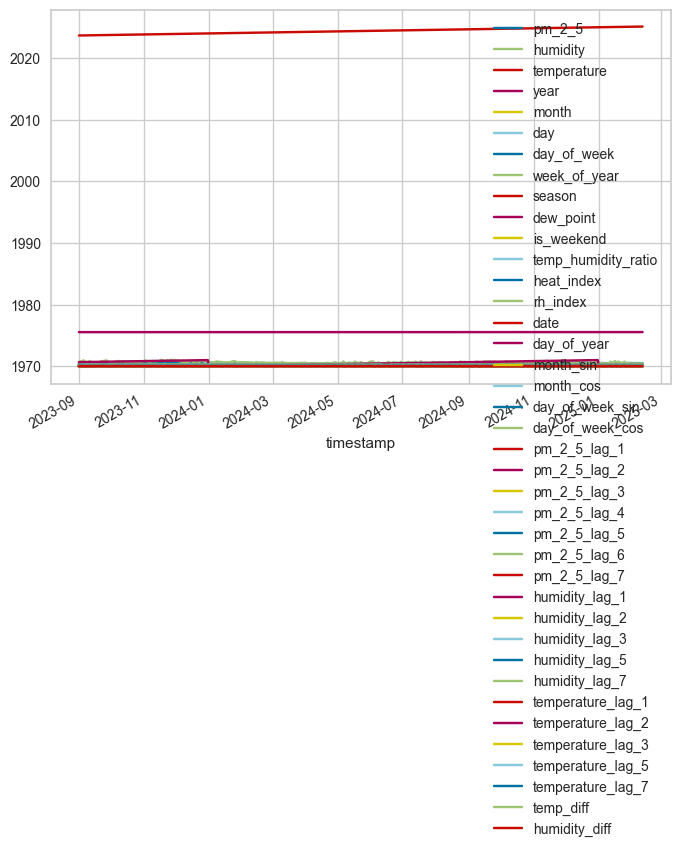

In [252]:
data_filtered.plot()

In [253]:
# สมมติว่า data มีจำนวนวันทั้งหมด
total_data = len(data_filtered)

# จำนวนวันที่ต้องการเป็น test data
test_days = 30

# คำนวณสัดส่วนของ 30 วันในข้อมูลทั้งหมด
test_size = test_days / total_data
test_size

0.05660377358490566

In [254]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_filtered, test_size=test_size, shuffle=False)

In [255]:
train_data.shape

(500, 39)

In [256]:
test_data.shape

(30, 39)

In [257]:
test_data.head(1)

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,humidity_lag_3,humidity_lag_5,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_5,temperature_lag_7,temp_diff,humidity_diff
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-13 07:00:00,42.594631,78.292202,25.997341,2025,1,13,0,3,2,21.655782,...,70.491487,71.168637,72.844643,25.434972,28.357459,28.945704,28.921543,28.825509,0.562369,-7.087604


In [258]:
test_data.tail(1)

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,humidity_lag_3,humidity_lag_5,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_5,temperature_lag_7,temp_diff,humidity_diff
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-11 07:00:00,27.522727,68.159624,28.693799,2025,2,11,1,7,0,22.325724,...,69.348548,69.511783,70.266522,28.251201,28.373742,28.385596,28.579177,27.775432,0.442598,-3.066711


In [259]:
test_data.tail()

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,humidity_lag_3,humidity_lag_5,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_5,temperature_lag_7,temp_diff,humidity_diff
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-07 07:00:00,29.321219,70.933952,28.271927,2025,2,7,4,6,0,22.458717,...,70.266522,70.341639,68.520368,28.579177,28.327450,27.775432,27.683890,27.336718,-0.307250,1.422170
2025-02-08 07:00:00,26.000000,69.348548,28.385596,2025,2,8,5,6,0,22.255305,...,71.500943,65.114261,69.231031,28.271927,28.579177,28.327450,28.644544,27.315410,0.113669,-1.585405
2025-02-09 07:00:00,24.616898,69.916384,28.373742,2025,2,9,6,6,0,22.357019,...,69.511783,70.266522,70.341639,28.385596,28.271927,28.579177,27.775432,27.683890,-0.011853,0.567837
2025-02-10 07:00:00,25.856981,71.226336,28.251201,2025,2,10,0,7,0,22.496468,...,70.933952,71.500943,65.114261,28.373742,28.385596,28.271927,28.327450,28.644544,-0.122542,1.309951
2025-02-11 07:00:00,27.522727,68.159624,28.693799,2025,2,11,1,7,0,22.325724,...,69.348548,69.511783,70.266522,28.251201,28.373742,28.385596,28.579177,27.775432,0.442598,-3.066711


In [260]:
test_data.columns

Index(['pm_2_5', 'humidity', 'temperature', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'season', 'dew_point', 'is_weekend',
       'temp_humidity_ratio', 'heat_index', 'rh_index', 'date', 'day_of_year',
       'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
       'pm_2_5_lag_1', 'pm_2_5_lag_2', 'pm_2_5_lag_3', 'pm_2_5_lag_4',
       'pm_2_5_lag_5', 'pm_2_5_lag_6', 'pm_2_5_lag_7', 'humidity_lag_1',
       'humidity_lag_2', 'humidity_lag_3', 'humidity_lag_5', 'humidity_lag_7',
       'temperature_lag_1', 'temperature_lag_2', 'temperature_lag_3',
       'temperature_lag_5', 'temperature_lag_7', 'temp_diff', 'humidity_diff'],
      dtype='object')

In [261]:
# train_data.dropna()

In [262]:
# from pycaret.time_series import *
from pycaret.regression import RegressionExperiment
exp1 = RegressionExperiment()
exp1.setup(data=train_data, target='pm_2_5', session_id=123, fold=12, iterative_imputation_iters=100, remove_outliers = True)

,Description,Value
0,Session id,123
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(500, 39)"
4,Transformed data shape,"(482, 41)"
5,Transformed train set shape,"(332, 41)"
6,Transformed test set shape,"(150, 41)"
7,Numeric features,37
8,Date features,1
9,Preprocess,True


In [263]:
# compare baseline models
best = exp1.compare_models(n_select=17)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,5.1063,44.2188,6.4932,0.5266,0.3431,0.3226,0.0208
llar,Lasso Least Angle Regression,5.1115,44.2643,6.4967,0.5262,0.3431,0.3229,0.0192
br,Bayesian Ridge,5.1382,44.7383,6.5352,0.5222,0.3457,0.3246,0.0183
en,Elastic Net,5.1270,44.7151,6.5293,0.5207,0.3453,0.3230,0.0192
omp,Orthogonal Matching Pursuit,5.1457,44.8714,6.5434,0.5194,0.3451,0.3261,0.0208
huber,Huber Regressor,5.1162,46.0862,6.5935,0.5094,0.3456,0.3067,0.0208
gbr,Gradient Boosting Regressor,5.3309,46.4344,6.6721,0.5060,0.3507,0.3370,0.0517
rf,Random Forest Regressor,5.3054,46.7517,6.6779,0.5057,0.3588,0.3508,0.0917
ridge,Ridge Regression,5.2611,46.4648,6.6861,0.5013,0.3776,0.3293,0.0242
ada,AdaBoost Regressor,5.4854,47.2316,6.7367,0.4964,0.3709,0.3801,0.0325


In [264]:
model_1 = exp1.create_model('rf')
# model_1 = exp1.create_model('en')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.3920,28.1040,5.3013,0.6909,0.3161,0.3013
1,7.7893,111.1562,10.5431,0.3876,0.4466,0.3869
2,4.5444,26.9542,5.1917,0.6317,0.4018,0.4597
3,6.2770,58.3960,7.6417,0.4802,0.4158,0.4385
4,4.4968,53.5889,7.3204,0.4845,0.2983,0.2259
5,5.5119,44.9527,6.7047,0.2507,0.4022,0.4372
6,5.7010,47.1947,6.8698,0.2290,0.3972,0.4226
7,6.1701,55.7743,7.4682,0.5610,0.4137,0.4331
8,4.0870,24.3771,4.9373,0.6857,0.2677,0.2481


In [265]:
exp1.evaluate_model(model_1)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [276]:
model_2 = exp1.create_model('br')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.8336,32.9426,5.7396,0.6377,0.3212,0.3154
1,7.2078,102.9841,10.1481,0.4326,0.4114,0.3385
2,3.8614,22.0595,4.6968,0.6986,0.3324,0.3510
3,5.4657,43.6399,6.6061,0.6115,0.3617,0.3646
4,5.1668,62.5850,7.9111,0.3980,0.3183,0.2451
5,5.3083,42.1228,6.4902,0.2979,0.3837,0.3940
6,5.4642,48.6332,6.9737,0.2055,0.3884,0.4021
7,5.8969,48.2235,6.9443,0.6205,0.3784,0.3866
8,4.6683,28.7732,5.3641,0.6290,0.2796,0.2770


In [277]:
new_data = test_data.copy().drop(['pm_2_5'], axis=1)
predictions = exp1.predict_model(model_2, data=new_data)
predictions.head()

,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,is_weekend,...,humidity_lag_5,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_5,temperature_lag_7,temp_diff,humidity_diff,prediction_label
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-13 07:00:00,78.292206,25.997341,2025,1,13,0,3,2,21.655781,0,...,71.168640,72.844643,25.434973,28.357460,28.945705,28.921543,28.825508,0.562369,-7.087604,25.302041
2025-01-14 07:00:00,74.887207,26.780884,2025,1,14,1,3,2,21.758324,0,...,70.983574,70.630295,25.997341,25.434973,28.357460,28.383165,29.145098,0.783542,-3.404998,33.523396
2025-01-15 07:00:00,74.201401,27.146723,2025,1,15,2,3,2,21.987003,0,...,70.491486,71.168640,26.780884,25.997341,25.434973,28.945705,28.921543,0.365839,-0.685802,39.623172
2025-01-16 07:00:00,89.873428,24.990604,2025,1,16,3,3,2,22.965288,0,...,73.568382,70.983574,27.146723,26.780884,25.997341,28.357460,28.383165,-2.156118,15.672023,33.368651
2025-01-17 07:00:00,80.848938,27.221664,2025,1,17,4,3,2,23.391453,0,...,85.379807,70.491486,24.990604,27.146723,26.780884,25.434973,28.945705,2.231061,-9.024486,35.101747


In [278]:
predict_v = predictions['prediction_label']

In [279]:
real = test_data['pm_2_5']

# ทำนาย 1 วันข้างหน้า ต้องทำนายเผื่อ 2 วัน

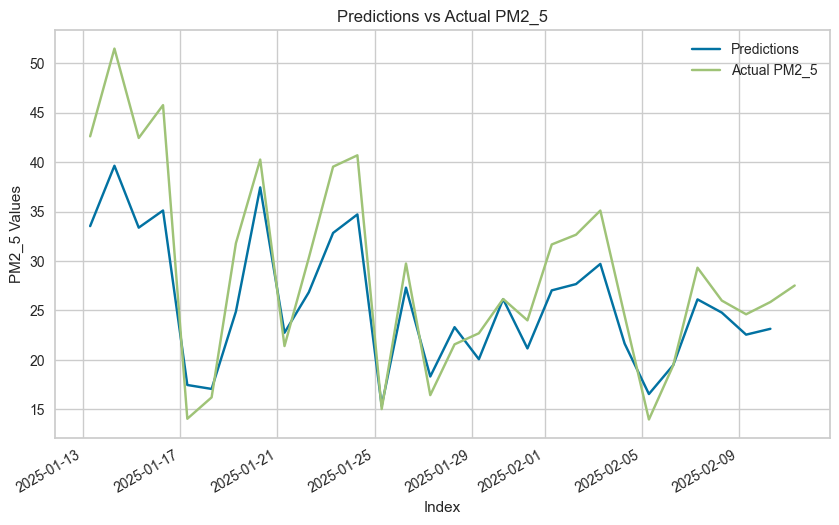

In [280]:
import pandas as pd
import matplotlib.pyplot as plt

# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result = pd.concat([predict_v.shift(-1), test_data['pm_2_5']], axis=1)
result.columns = ['Predictions', 'Actual PM2_5']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM2_5')
plt.xlabel('Index')
plt.ylabel('PM2_5 Values')

# แสดงกราฟ
plt.show()

In [271]:
# import pandas as pd
# from sklearn.metrics import mean_absolute_percentage_error, r2_score

# # สร้าง result จากการ shift ค่าทำนาย
# result = pd.concat([predict_v.shift(-1), test_data['pm_10']], axis=1)
# result.columns = ['predicted', 'actual']

# # ลบแถวที่มีค่า NaN
# result = result.dropna()

# # คำนวณ MAPE
# mape = mean_absolute_percentage_error(result['actual'], result['predicted']) * 100

# # คำนวณ R2
# r2 = r2_score(result['actual'], result['predicted'])

# print(f'MAPE: {mape}%')
# print(f'R²: {r2}')


# Predict 1 by 1

30 วัน  
2025-01-13 07:00:00  
2025-02-11 07:00:00  
7 วัน  
2025-02-05  
2025-02-11  
24 วัน  
2025-01-19 07:00:00  
31 วัน
2025-01-12 07:00:00

In [281]:
data_compare = data_filtered.loc[:'2025-01-12']
result = pd.DataFrame()

start_date = "2025-01-13"
end_date = "2025-02-11"

model = model_2

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered

    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    # เพิ่มฟีเจอร์ rolling average (ค่าเฉลี่ยเคลื่อนที่)

    # data_compare['pm_2_5_rolling_7'] = data_compare['pm_2_5'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10

    data_compare['pm_2_5_lag_1'] = data_compare['pm_2_5'].shift(1)
    data_compare['pm_2_5_lag_2'] = data_compare['pm_2_5'].shift(2)
    data_compare['pm_2_5_lag_3'] = data_compare['pm_2_5'].shift(3)
    data_compare['pm_2_5_lag_4'] = data_compare['pm_2_5'].shift(4)
    data_compare['pm_2_5_lag_5'] = data_compare['pm_2_5'].shift(5)
    data_compare['pm_2_5_lag_6'] = data_compare['pm_2_5'].shift(6)
    data_compare['pm_2_5_lag_7'] = data_compare['pm_2_5'].shift(7)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['pm_2_5'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = exp1.predict_model(model, data=test_1)

        # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'pm_2_5'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result
    result = pd.concat([result, predict_test_1], axis=0)

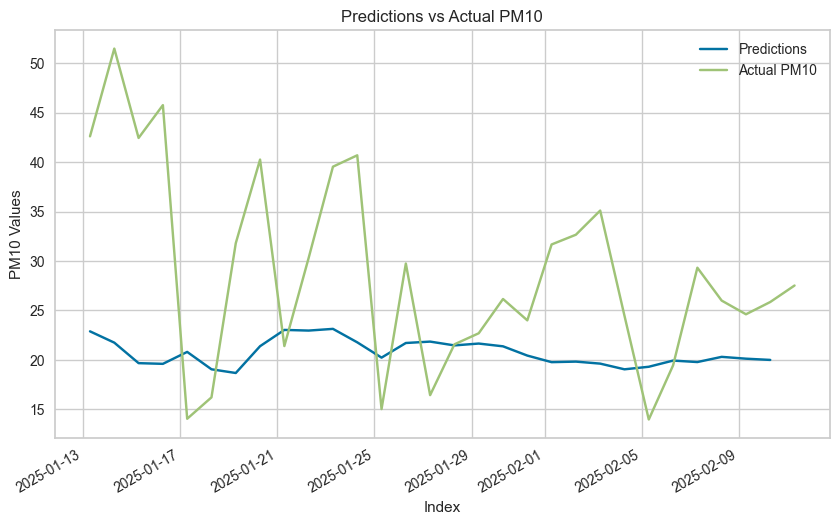

In [282]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['pm_2_5']], axis=1)
result_plot.columns = ['Predictions', 'Actual PM10']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result_plot.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM10')
plt.xlabel('Index')
plt.ylabel('PM10 Values')

# แสดงกราฟ
plt.show()

In [283]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_true = real_data["pm_2_5"][:"2025-2-10"]
y_pred = result['prediction_label'].shift(-1).dropna(axis=0)# "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = (1 - (mae / mean_actual)) * 100  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage

R² Score: -0.6167
Mean Absolute Error (MAE): 9.9714
Root Mean Squared Error (RMSE): 12.6930
Accuracy: 65.38%


In [275]:
# ค่า R² และ MAPE
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE in percentage

# การปรับสเกลของ R² (สมมติให้อยู่ในช่วง 0-100 เพื่อให้อยู่ในช่วงเดียวกับ MAPE)
r2_scaled = r2 * 100  # เปลี่ยน R² ให้เป็นค่าร้อยละ

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



R² Score: -0.6780
Mean Absolute Percentage Error (MAPE): 31.51%
